# Langevin dynamics simulation of the vibrational motion of HF

As described in the companion document to this notebook, this exercise involves using the BBK integrator to perform a Langevin dynamics simulation of the HF molecule

We will start by importing a few useful libraries - these are packages of python code that provide capabilities to do numerical calculations, plot data, etc. We will then create arrays (or lists) for the bond length and energies at each bond length as in last week's computational exercise. 

In [2]:
import numpy as np
from matplotlib import pyplot as plt
from scipy.interpolate import InterpolatedUnivariateSpline

molecules = []
r_array = [0.5, 0.55,0.6,0.65,0.7,0.75,0.8,0.85,0.9,0.95,1.0,1.1,1.2,1.3,1.4,1.5,1.6,1.7,1.8,1.9,2.0,2.1,2.2,2.3] 
E_array = [-99.65145319155353, -99.8994262443721,-100.06621001317194,-100.17756325854646,-100.25063259195414,-100.2970313588523,-100.32474168482375,-100.33931605978479,-100.34465565789081,-100.34352787324143,-100.33791544225228,-100.31857920174716,-100.29403975969775,-100.26820624042988,-100.24311492569184,-100.21980547092805,-100.19879112534593,-100.18029259214076,-100.16434868570335,-100.15087255990257,-100.13968771534014,-100.13055798203477,-100.12321514624568,-100.11738316835266]

We now fit our energy potential surface using a *spline* just like in the previous computational exercise. We will then differentiate this spline to obtain a force (and differentiate the force to obtain our spring constant). While we are setting things up, let us also calculate the equilibrium both length for HF and the reduced mass of HF in atomic units (just like last time). We'll also need to perform the same interpolation as last time.

In [3]:
''' Create array of bond lengths in atomic units called r_array_au and fit PES to splines in this cell! '''
r_array_au = np.array(r_array) * 1.89
''' create a cubic spline for the energies vs bond length in atomic units here! '''
E_spline = InterpolatedUnivariateSpline(r_array_au, E_array, k=3)

### form a much finer grid to evaluate spline object at
r_fine = np.linspace(0.5*1.89,2.3*1.89,200)
### compute the interpolated/extrapolated values for Energy on this grid
E_fine = E_spline(r_fine)
minE = min(E_fine)

fE = E_spline.derivative()
cE = fE.derivative()

### Find Equilibrium Bond-Lengths for each level of theory
Req_idx = np.argmin(E_fine)

### find the value of the separation corresponding to that index
r_eq = r_fine[Req_idx]

### print equilibrium bond-lengths at each level of theory!
print(" Equilibrium bond length is ",r_eq, "atomic units")
print(" Req is ",r_eq/1.89, "Angstroms")

### mass of hydrogen in atomic units
mH = 1836.
### mass of fluorine in atomic units
mF = 34883.

''' compute reduced mass and store it to variable mu here! '''
mu = mH * mF/(mH + mF)
### Print the reduced mass!
print("Reduced mass is ",mu, "atomic units")

### evaluate the second derivative at r_eq to get k
k = cE(r_eq)
### print the spring constant
print("The spring constant for the HF molecule viewed as a harmonic oscillator is ", k, "atomic units")

 Equilibrium bond length is  1.7313919597989949 atomic units
 Req is  0.9160804020100503 Angstroms
Reduced mass is  1744.1974999319154 atomic units
The spring constant for the HF molecule viewed as a harmonic oscillator is  0.6400845065940467 atomic units


For our simulation of HF motion as a function of time, we need to define an initial state for our molecule. Since our molecule is being constantly perturbed by external forces (e.g. solvent molecules), it need not be in its lowest energy state, but rather it is in some "random" relatively low energy state.

In [4]:
### define "ground-state" velocity:
v = np.sqrt( np.sqrt(k/mu)/(2*mu))

### get random position and velocity for HF within a reasonable range:
### to think about: are these ranges reasonable given the temperature at which we want to simulate our system?
###                 how would you evaluate the reasonability of these initial conditions?
r_init = np.random.uniform(0.5*r_eq,1.5*r_eq)
v_init = np.random.uniform(-v,v)

### print initial position and velocity
print("Initial separation is ",r_init, "atomic units")
print("Initial velocity is   ",v_init, "atomic units")
### establish time-step for integration to be 0.02 atomic units... this is about 0.01 femtoseconds
### you may want to see what happens (e.g. to mean "instantaneous temperature" when you change this number)
dt = 0.02

### get force on particle 
F_init = -1*fE(r_init)

Initial separation is  1.1705618475806152 atomic units
Initial velocity is    0.00042789505044430517 atomic units


Now we need to set up some parameters for our Langevin dynamics run. Changing our initial state (re-running the code above) will change the resulting Langevin dynamics trajectory as will changing the parameters below (re-running the code below). Let's calculate the average HF bond-length at the given temperature, while we are at it.

In [6]:
### parameters for Langevin Equation: temperature and drag
### note that in atomic units, the Boltzmann constant is unity
temperature = 0.00094 # approximately room temperature (295 K) in atomic units
gamma = 0.01; # this gamma may be a bit high ... you may want to see what happens when you decrease this number

### use parameters set above to get initial perturbation of force for Langevin dynamics
rp_init = np.sqrt(2*temperature*gamma*mu/dt)*np.random.normal(0,1)

# note that exp(-E_shifted) = exp(-E_fine)*exp(100) ... so "shifting" gives us equivalent Boltzmann distribution
# but with easier to deal with numbers following exponentiation

E_shifted = E_fine+100 

''' code for calculating (weighted, according to Boltzmann distribution) average bond length goes here '''
r_av = np.sum(np.multiply(r_fine,np.exp(-E_shifted/temperature)))/np.sum(np.exp(-E_shifted/temperature))

### print average bond-length in different units
print(" Equilibrium bond length is ",r_av, "atomic units")
print(" R_av is ",r_av/1.89, "Angstroms")


 Equilibrium bond length is  1.7304972864945398 atomic units
 R_av is  0.915607029891291 Angstroms


Next we need to define our BBK function and call it to update our position and velocity. Note that in each BBK update of our velocity we need to know our current random perturbation of the force as well as the random perturbation of force at the next time step. One way to keep track of the perturbations is to output the perturbation for the next time step to use as the current perturbation in the next BBK function call: thus we need to have the current perturbation be input to the BBK function call. We also need to input the drag coefficient, gamma, and the temperature ... since the Boltzmann constant is unity in atomic units, we do not need to worry about it) into the BBK function. The following partially-complete function will update the position. You should complete the function to also update the velocity (note: Remove lines that update velocity and have students implement them).

In [7]:
def BBK(r_curr, v_curr, rp_curr, gamma_val, temperature_val, mu, f_interp, dt):
    ### get acceleration at current time: (force + current perturbation on force)/mass - drag
    a_curr = (-1*f_interp(r_curr) + rp_curr)/mu - gamma_val*v_curr
    
    ### update velocity for half time step, for such a small time step can approximate dv = adt
    
    # v_halftime = v_curr + 0.5*a_curr*dt
    
   
    ### use current acceleration and velocity to update position
    r_fut = r_curr + v_curr * dt + 0.5 * a_curr * dt**2
    
    ### calculate the rp_future
    
    rp_fut = np.sqrt(2*temperature_val*gamma_val*mu/dt)*np.random.normal(0,1)
    
    ### use rp_fut to get future acceleration a_fut (a_tilde at the future time in the assignment), 
    ### note that we cannot take future drag into account as we have not calculated our future velocity yet
    a_fut = (-1*f_interp(r_fut) + rp_fut)/mu
    
    ### use current and future acceleration to get future velocity v_fut
    ### note that we have to "correct" our formula relative to the formula for velocity Verlet
    ### as we have not included our future drag in our future acceleration
    
    # v_fut = (v_halftime + 0.5*a_fut*dt)/(1+0.5*gamma_val*dt)
    v_fut = (v_curr + 0.5*(a_curr + a_fut)*dt)/(1+0.5*gamma_val*dt)
    
    # v_fut = v_curr + 0.5 * (a_curr + a_fut) * dt
    
    result = [r_fut, v_fut, rp_fut]
    
    return result

Now that we have implemented the BBK algorithm as a python function, let's actually try using it to simulate HF bond vibrations.

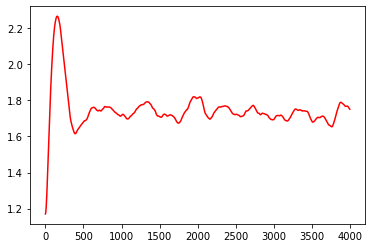

Mean bond-length for last 30000 time steps of the trajectory is  0.9093554058634263  Angstroms


'comparison code from a previous exercise as a hint:'

In [18]:
### how many updates do you want to perform?
N_updates = 200000

### Now use r_init and v_init and run velocity verlet update N_updates times, plot results
### these arrays will store the time, the position vs time, and the velocity vs time
### as weell as energy and "instantaneous temperature" (Eq. 3.18 in Cramer, note that we have 1 dof)
r_vs_t = np.zeros(N_updates)
v_vs_t = np.zeros(N_updates)
e_vs_t = np.zeros(N_updates)
temp_vs_t = np.zeros(N_updates)
t_array = np.zeros(N_updates)

### first entry is the intial position and velocity
r_vs_t[0] = r_init
v_vs_t[0] = v_init
e_vs_t[0] = (E_spline(r_init)-minE)+0.5*mu*v_init**2 
temp_vs_t[0] = mu*v_init**2 # note k_B is unity in atomic units, so no need to divide by anything

### first BBK update
### note that the result of a BBK call is an array whose elements are position, velocity and a perturbation term
result_array = BBK(r_init, v_init, rp_init, gamma, temperature, mu, fE, dt)

### do the update N_update-1 more times
for i in range(1,N_updates):
    tmp = BBK(result_array[0], result_array[1], result_array[2], gamma, temperature, mu, fE, dt)
    result_array = tmp
    t_array[i] = dt*i
    r_vs_t[i] = result_array[0]
    v_vs_t[i] = result_array[1]
    e_vs_t[i] = (E_spline(result_array[0])-minE)+0.5*mu*result_array[1]**2
    temp_vs_t[i] = mu*result_array[1]**2 # = 2 x the kinetic energy which is 0.5*mu*v**2

### Plot the trajectory of bondlength vs time:
plt.plot(t_array, r_vs_t, 'red')
plt.show()

### print mean bond-length for the last thirty thousand steps
'''code for printing mean bond length for last 30000 time steps goes here'''
print("Mean bond-length for last 30000 time steps of the trajectory is ",np.mean(r_vs_t[(N_updates-30000):N_updates])/1.89," Angstroms")


'''comparison code from a previous exercise as a hint:'''
# print("Mean temperature for last 10000 time steps of the trajectory is ",np.mean(temp_vs_t[(N_updates-10000):N_updates])," Hartrees")
    

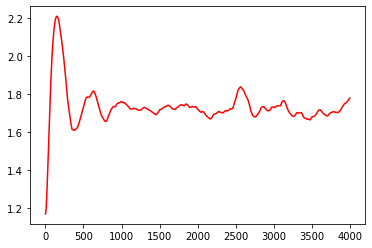

Mean bond-length for last 30000 time steps of the trajectory is  0.902469096537346  Angstroms


'comparison code from a previous exercise as a hint:'

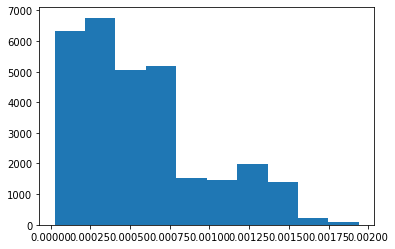

In [19]:
### how many updates do you want to perform?
N_updates = 200000

### Now use r_init and v_init and run velocity verlet update N_updates times, plot results
### these arrays will store the time, the position vs time, and the velocity vs time
### as weell as energy and "instantaneous temperature" (Eq. 3.18 in Cramer, note that we have 1 dof)
r_vs_t = np.zeros(N_updates)
v_vs_t = np.zeros(N_updates)
e_vs_t = np.zeros(N_updates)
temp_vs_t = np.zeros(N_updates)
t_array = np.zeros(N_updates)

### first entry is the intial position and velocity
r_vs_t[0] = r_init
v_vs_t[0] = v_init
e_vs_t[0] = (E_spline(r_init)-minE)+0.5*mu*v_init**2 
temp_vs_t[0] = mu*v_init**2 # note k_B is unity in atomic units, so no need to divide by anything

### first BBK update
### note that the result of a BBK call is an array whose elements are position, velocity and a perturbation term
result_array = BBK(r_init, v_init, rp_init, gamma, temperature, mu, fE, dt)

### do the update N_update-1 more times
for i in range(1,N_updates):
    tmp = BBK(result_array[0], result_array[1], result_array[2], gamma, temperature, mu, fE, dt)
    result_array = tmp
    t_array[i] = dt*i
    r_vs_t[i] = result_array[0]
    v_vs_t[i] = result_array[1]
    e_vs_t[i] = (E_spline(result_array[0])-minE)+0.5*mu*result_array[1]**2
    temp_vs_t[i] = mu*result_array[1]**2 # = 2 x the kinetic energy which is 0.5*mu*v**2

### Plot the trajectory of bondlength vs time:
plt.plot(t_array, r_vs_t, 'red')
plt.show()

### print mean bond-length for the last thirty thousand steps
'''code for printing mean bond length for last 30000 time steps goes here'''
print("Mean bond-length for last 30000 time steps of the trajectory is ",np.mean(r_vs_t[(N_updates-30000):N_updates])/1.89," Angstroms")
plt.hist(e_vs_t[(N_updates-30000):N_updates])
'''comparison code from a previous exercise as a hint:'''
# print("Mean temperature for last 10000 time steps of the trajectory is ",np.mean(temp_vs_t[(N_updates-10000):N_updates])," Hartrees")
    

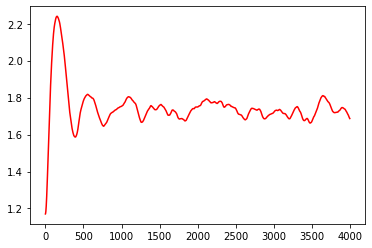

Mean bond-length for last 30000 time steps of the trajectory is  0.9167766043907565  Angstroms


'comparison code from a previous exercise as a hint:'

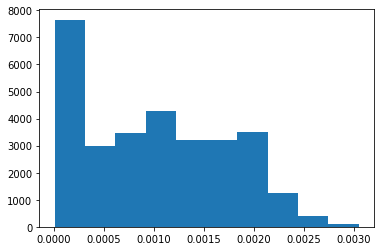

In [23]:
### how many updates do you want to perform?
N_updates = 200000

### Now use r_init and v_init and run velocity verlet update N_updates times, plot results
### these arrays will store the time, the position vs time, and the velocity vs time
### as weell as energy and "instantaneous temperature" (Eq. 3.18 in Cramer, note that we have 1 dof)
r_vs_t = np.zeros(N_updates)
v_vs_t = np.zeros(N_updates)
e_vs_t = np.zeros(N_updates)
temp_vs_t = np.zeros(N_updates)
t_array = np.zeros(N_updates)

### first entry is the intial position and velocity
r_vs_t[0] = r_init
v_vs_t[0] = v_init
e_vs_t[0] = (E_spline(r_init)-minE)+0.5*mu*v_init**2 
temp_vs_t[0] = mu*v_init**2 # note k_B is unity in atomic units, so no need to divide by anything

### first BBK update
### note that the result of a BBK call is an array whose elements are position, velocity and a perturbation term
result_array = BBK(r_init, v_init, rp_init, gamma, temperature, mu, fE, dt)

### do the update N_update-1 more times
for i in range(1,N_updates):
    tmp = BBK(result_array[0], result_array[1], result_array[2], gamma, temperature, mu, fE, dt)
    result_array = tmp
    t_array[i] = dt*i
    r_vs_t[i] = result_array[0]
    v_vs_t[i] = result_array[1]
    e_vs_t[i] = (E_spline(result_array[0])-minE)+0.5*mu*result_array[1]**2
    temp_vs_t[i] = mu*result_array[1]**2 # = 2 x the kinetic energy which is 0.5*mu*v**2

### Plot the trajectory of bondlength vs time:
plt.plot(t_array, r_vs_t, 'red')
plt.show()

### print mean bond-length for the last thirty thousand steps
print("Mean bond-length for last 30000 time steps of the trajectory is ",np.mean(r_vs_t[(N_updates-30000):N_updates])/1.89," Angstroms")
'''code for printing mean bond length for last 30000 time steps goes here'''
plt.hist(e_vs_t[(N_updates-30000):N_updates])
'''comparison code from a previous exercise as a hint:'''
# print("Mean temperature for last 10000 time steps of the trajectory is ",np.mean(temp_vs_t[(N_updates-10000):N_updates])," Hartrees")
    

In [22]:
### Metropolis Monte-Carlo Code

r_accepted_array = np.zeros(N_updates)
num_accepted_r = 0
r_prev = r_init

E_spline_shifted = InterpolatedUnivariateSpline(r_array_au, np.add(E_array,100), k=3)
    # think about it: why is it OK to shift energies like this? why do we want to do so?

for i in range(0,N_updates):
    # create a potential new position by perturbing old position:
    # try perturbing old position by a random: normally distributed with mean 0 and standard deviation of 1 atomic unit
    
    r_trial = r_prev + np.random.normal(0,1)
    
    # equation 3.34 in textbook
    p = np.exp(-E_spline_shifted(r_trial)/temperature)/np.exp(-E_spline_shifted(r_prev)/temperature)
                                                                               

    # note: we don't have to worry about what happens when p > 1 as it will always produce true when compared to a 
    # random value drawn from a uniform distribution on (0,1), c.f. below
    # "roll the dice": accept r_trial if uniformly distributed random variable is < p
    if(np.random.uniform()<p):
        r_accepted_array[num_accepted_r] = r_trial
        num_accepted_r = num_accepted_r + 1
        r_prev = r_trial

r_av_mc = np.mean(r_accepted_array[0:num_accepted_r])
print("Mean HF bond-length from Metropolis Monte Carlo is ", r_av_mc/1.89, " Angstroms")

print("Acceptance rate is ", 100*num_accepted_r/N_updates, " %")

Mean HF bond-length from Metropolis Monte Carlo is  0.9159919449404293  Angstroms
Acceptance rate is  4.8095  %
